In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [9]:
with open('train_config.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [10]:
default_train_config

{'region_name': '',
 'region_type': '',
 'train_start_date': '',
 'train_end_date': '',
 'model_class': 'SEIHRD',
 'model_parameters': {'incubation_period': 5, 'F_icu': 0.05},
 'search_space': {'r0': [0.5, 6],
  'EbyCRatio': [0.01, 70],
  'IbyCRatio': [0.01, 2],
  'infectious_period': [1, 10],
  'F_hospitalization': [0.04, 0.125],
  'F_fatalities': [0.02, 0.12]},
 'search_parameters': {'max_evals': 10},
 'training_loss_function': {'metric_name': 'mape',
  'variable_weights': [{'variable': 'confirmed', 'weight': 1},
   {'variable': 'recovered', 'weight': 1},
   {'variable': 'deceased', 'weight': 1},
   {'variable': 'hospitalized', 'weight': 1}]},
 'loss_functions': [{'metric_name': 'mape',
   'variable_weights': [{'variable': 'confirmed', 'weight': 1}]},
  {'metric_name': 'mape',
   'variable_weights': [{'variable': 'hospitalized', 'weight': 1}]},
  {'metric_name': 'rmsle',
   'variable_weights': [{'variable': 'confirmed', 'weight': 1}]}],
 'output_filepath': ''}

In [11]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [14]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date,
               max_evals = 1000, data_source = None, 
               mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = train_config['model_class']
       
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics['Train1All'] = trainResults['train_metric_results']
    metrics.update(parse_params(trainResults['best_params'], 'Train1'))
    metrics.update(parse_params(trainResults['latent_params'], 'Train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    metrics['TestAll'] = evalResults
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics['Train2All'] = finalResults['train_metric_results']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
    metrics.update(parse_params(finalResults['latent_params'], 'Train2'))
        
    model_params['model_parameters'] = finalResults['model_parameters']
    
    return params, metrics, model_params

In [ ]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
run_day = '4/17/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 1000,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

t = 10.90                                               
t = 10.90                                               
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                       

t = 10.90                                                                         
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                    

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                         
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90      

t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
 75%|███████▌  | 754/1000 [01:08<00:23, 10.47trial/s, best loss: 4278.342136

In [16]:
params

{'region': 'mumbai',
 'region_type': 'district',
 'train1_start_date': '4/8/20',
 'train1_end_date': '4/17/20',
 'train2_start_date': '4/13/20',
 'train2_end_date': '4/22/20',
 'run_day': '4/17/20',
 'test_start_date': '4/18/20',
 'test_end_date': '4/22/20',
 'data_source': None}

In [17]:
metrics

{'Train1MAPE': 1090.0932150293734,
 'Train1RMLSE': 311.6103952894429,
 'Train1All': [{'metric_name': <MetricName.mape: 'mape'>,
   'variable_weights': [{'variable': <ForecastVariable.confirmed: 'confirmed'>,
     'weight': 1.0}],
   'value': 1090.0932150293734},
  {'metric_name': <MetricName.mape: 'mape'>,
   'variable_weights': [{'variable': <ForecastVariable.hospitalized: 'hospitalized'>,
     'weight': 1.0}],
   'value': 311.6103952894429},
  {'metric_name': <MetricName.rmsle: 'rmsle'>,
   'variable_weights': [{'variable': <ForecastVariable.confirmed: 'confirmed'>,
     'weight': 1.0}],
   'value': 2.3214305929003713}],
 'Train1_EbyCRatio': 60.15445668438553,
 'Train1_F_fatalities': 0.09812410711319197,
 'Train1_F_hospitalization': 0.07847561357491734,
 'Train1_IbyCRatio': 0.8174959071661886,
 'Train1_infectious_period': 7.81787183959432,
 'Train1_r0': 4.949897642693982,
 'Train1_LatentEbyCRatio_4/7/20': 60.15445668438553,
 'Train1_LatentEbyCRatio_4/17/20': 4.833128832413304,
 'Trai

In [18]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIHRD',
 'model_parameters': {'incubation_period': 5,
  'F_icu': 0.05,
  'EbyCRatio': 10.268857091812668,
  'F_fatalities': 0.11305592320078144,
  'F_hospitalization': 0.10646218611292912,
  'IbyCRatio': 0.20061855226832445,
  'infectious_period': 3.34514198831545,
  'r0': 2.762621748280257,
  'LatentEbyCRatio': {'4/12/20': 10.268857091812668,
   '4/22/20': 0.9966197856961576},
  'LatentIbyCRatio': {'4/12/20': 0.20061855226832445,
   '4/22/20': 0.312764810986855},
  'MAPE': 21867.96008710807}}

In [9]:
model_params['model_parameters']['incubation_period'] = 5

In [21]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIHRD',
 'model_parameters': {'incubation_period': 5,
  'F_hospitalization': 0.04,
  'F_icu': 0.05,
  'F_fatalities': 0.08,
  'EbyCRatio': 0.5811885835336268,
  'IbyCRatio': 0.9336569190367185,
  'infectious_period': 5.784009421726601,
  'r0': 0.7128930885318407,
  'LatentEbyCRatio': {'4/12/20': 0.5811885835336268,
   '4/22/20': 0.2321258410198151},
  'LatentIbyCRatio': {'4/12/20': 0.9336569190367185,
   '4/22/20': 0.1404429097319697},
  'MAPE': 3.291571740235837}}

In [22]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [23]:
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)

t = 10.90


In [24]:
forecast_df

prediction_type,index,exposed,icu_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_mean,infected,final,...,hospitalized_min,hospitalized_max,icu_min,icu_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max
0,4/13/20,770.189527,50.015498,462.192791,40.190677,1502.693436,1000.309967,1000.309967,1158.899752,502.383469,...,967.384047,1033.235887,48.369202,51.661794,446.979384,477.406198,38.867773,41.513582,1453.231203,1552.155668
1,4/14/20,777.436565,41.479817,800.148636,69.578142,1699.323122,829.596344,829.596344,1117.155573,869.726778,...,802.289585,856.903102,40.114479,42.845155,773.811170,826.486102,67.287928,71.868357,1643.388682,1755.257561
2,4/15/20,778.861721,35.540907,1084.481512,94.302740,1889.602390,710.818137,710.818137,1082.346387,1178.784252,...,687.421048,734.215226,34.371052,36.710761,1048.785025,1120.177999,91.198698,97.406783,1827.404771,1951.800008
3,4/16/20,775.810957,31.359375,1331.344468,115.769084,2074.301051,627.187499,627.187499,1052.991263,1447.113552,...,606.543172,647.831825,30.327159,32.391591,1287.522310,1375.166626,111.958462,119.579707,2006.023944,2142.578158
4,4/17/20,769.261332,28.370519,1551.655164,134.926536,2253.992077,567.410376,567.410376,1028.012693,1686.581700,...,548.733657,586.087096,27.436683,29.304355,1500.581321,1602.729007,130.485332,139.367740,2179.800310,2328.183843
5,4/18/20,760.603959,26.208082,1752.881356,152.424466,2429.467470,524.161649,524.161649,1005.880670,1905.305822,...,506.908492,541.414805,25.345425,27.070740,1695.184009,1810.578703,147.407305,157.441626,2349.499806,2509.435135
6,4/19/20,751.271369,24.628442,1940.253785,168.717720,2601.540351,492.568846,492.568846,985.020052,2108.971505,...,476.355589,508.782103,23.817779,25.439105,1876.388940,2004.118630,163.164256,174.271185,2515.908784,2687.171918
7,4/20/20,741.163571,23.435555,2117.378035,184.119829,2770.208963,468.711098,468.711098,965.531183,2301.497865,...,453.283136,484.139060,22.664157,24.206953,2047.683018,2187.073052,178.059393,190.180265,2679.025547,2861.392378
8,4/21/20,730.350967,22.503750,2286.647284,198.838894,2935.561178,450.075000,450.075000,947.328290,2485.486178,...,435.260459,464.889542,21.763023,23.244477,2211.380648,2361.913919,192.293969,205.383819,2838.935076,3032.187281
9,4/22/20,719.073405,21.753020,2449.696552,213.017092,3097.774044,435.060400,435.060400,930.140500,2662.713644,...,420.740075,449.380726,21.037004,22.469036,2369.063033,2530.330072,206.005481,220.028702,2995.808589,3199.739499


In [25]:
def get_observations_in_range(region_name, region_type, 
                              start_date, end_date,
                              obs_type = 'confirmed'):
    """
        Return a list of counts of obs_type cases
        from the region in the specified date range.
    """
    observations = DataFetcherModule.get_observations_for_region(region_type, region_name)
    observations_df = observations[observations['observation'] == obs_type]
    
    start_date = datetime.strptime(start_date, '%m/%d/%y')
    end_date = datetime.strptime(end_date, '%m/%d/%y')
    delta = (end_date - start_date).days
    days = []
    for i in range(delta + 1):
        days.append((start_date + timedelta(days=i)).strftime('%-m/%-d/%-y'))
    
    # Fetch observations in the date range
    observations_df = observations_df[days]
    
    # Transpose the df to get the
    # observations_df.shape = (num_days, 1)
    observations_df = observations_df.reset_index(drop=True).transpose()
    
    # Rename the column to capture observation type
    # Note that the hardcoded 0 in the rename comes from the reset_index
    # from the previous step
    observations = observations_df[0].to_list()
    return observations

In [26]:
forecast_df.columns

Index(['index', 'exposed', 'icu_mean', 'recovered_mean', 'deceased_mean',
       'confirmed_mean', 'hospitalized_mean', 'active_mean', 'infected',
       'final', 'active_min', 'active_max', 'hospitalized_min',
       'hospitalized_max', 'icu_min', 'icu_max', 'recovered_min',
       'recovered_max', 'deceased_min', 'deceased_max', 'confirmed_min',
       'confirmed_max'],
      dtype='object', name='prediction_type')

In [27]:
observations = get_observations_in_range('mumbai', 'district', '4/13/20', '4/22/20')

In [28]:
forecast_df['actual_confirmed'] = observations

In [31]:
forecast_df[['confirmed_mean', 'hospitalized_mean', 'recovered_mean', 'icu_mean', 'final', 'deceased_mean', 'actual_confirmed']]

prediction_type,confirmed_mean,hospitalized_mean,recovered_mean,icu_mean,final,deceased_mean,actual_confirmed
0,1502.693436,1000.309967,462.192791,50.015498,502.383469,40.190677,1540.0
1,1699.323122,829.596344,800.148636,41.479817,869.726778,69.578142,1756.0
2,1889.602390,710.818137,1084.481512,35.540907,1178.784252,94.302740,1896.0
3,2074.301051,627.187499,1331.344468,31.359375,1447.113552,115.769084,2073.0
4,2253.992077,567.410376,1551.655164,28.370519,1686.581700,134.926536,2085.0
5,2429.467470,524.161649,1752.881356,26.208082,1905.305822,152.424466,2268.0
6,2601.540351,492.568846,1940.253785,24.628442,2108.971505,168.717720,2724.0
7,2770.208963,468.711098,2117.378035,23.435555,2301.497865,184.119829,2912.0
8,2935.561178,450.075000,2286.647284,22.503750,2485.486178,198.838894,2913.0
9,3097.774044,435.060400,2449.696552,21.753020,2662.713644,213.017092,3145.0


In [32]:
def plot(model_params, forecast_df, forecast_start_date, forecast_end_date, plot_name = 'default.png'):
    """
        Plot actual_confirmed cases vs forecasts.
        
        Assert that forecast_end_date is prior to the current date
        to ensure availability of actual_counts.
    """
    # Check for forecast_end_date being prior to current date
    end_date = datetime.strptime(forecast_end_date, '%m/%d/%y')
    assert end_date < datetime.now()    
    
    # Fetch actual counts from the DataFetcher module
    region_name = model_params['region']
    region_type = model_params['region_type']
    actual_observations = DataFetcherModule.get_observations_for_region(region, region_type)
    
    # Get relevant time-series of actual counts from actual_observations
    actual_observations = get_observations_in_range(region_name, region_type, 
                                                    forecast_start_date, 
                                                    forecast_end_date,
                                                    obs_type = 'confirmed')
    
    forecast_df['actual_confirmed'] = actual_observations
    
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(model_params['region'])
    ax.plot(forecast_df['index'], forecast_df['actual_confirmed'], color='blue', label="actual_confirmed")
    ax.plot(forecast_df['index'], forecast_df['confirmed_mean'], color='orange', label="predicted_confirmed")
    ax.set_ylim(ymin=0)
    ax.legend()

    plt.savefig(plot_name)

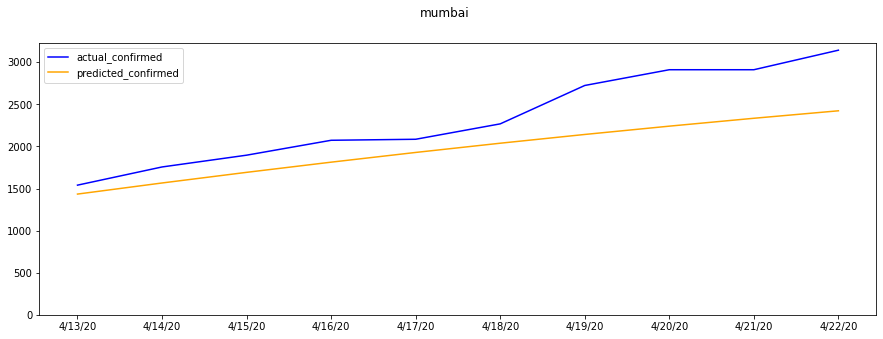

In [33]:
plot(model_params, forecast_df, forecast_start_date, forecast_end_date)

In [37]:
def train_eval_forecast(region, region_type, 
                        train1_start_date, train1_end_date, 
                        train2_start_date, train2_end_date,
                        test_run_day, test_start_date, test_end_date, 
                        forecast_run_day, forecast_start_date, forecast_end_date,
                        max_evals = 1000, 
                        data_source = None, mlflow_log = True, name_prefix = None,
                        plot_actual_vs_predicted = False, plot_name = 'default.png'):
    """
        Run train, evaluation and generate forecasts as a dataframe.
        
        If plot_actual_vs_predicted is set to True,
        we first check if the forecast_end_date is prior to the current date
        so that we have actual_confirmed cases and then plot the predictions.
    """
    params, metrics, model_params = train_eval(region, region_type, 
                                               train1_start_date, train1_end_date, 
                                               train2_start_date, train2_end_date, 
                                               test_run_day, test_start_date, test_end_date, 
                                               max_evals, data_source, 
                                               mlflow_log, name_prefix)
    model_params['model_parameters']['incubation_period'] = 5
    forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)
    
    if plot_actual_vs_predicted:
        # Check for forecast_end_date being prior to current date
        end_date = datetime.strptime(forecast_end_date, '%m/%d/%y')
        assert end_date < datetime.now()

        plot(model_params, forecast_df, forecast_start_date, forecast_end_date, plot_name)
    return forecast_df, params, metrics, model_params

In [ ]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
test_run_day = '4/17/20'
forecast_run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
name_prefix = 'mumbai_sample'

train_eval_forecast(region, region_type, 
                    train1_start_date, train1_end_date, 
                    train2_start_date, train2_end_date,
                    test_run_day, test_start_date, test_end_date, 
                    forecast_run_day, forecast_start_date, forecast_end_date,
                    max_evals = 10, 
                    mlflow_log = False, name_prefix = name_prefix,
                    plot_actual_vs_predicted = 'True',
                    plot_name = 'default.png')

t = 10.90                                             
t = 10.90                                             
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                      
t = 10.90                                                                      
t = 10.90                                                                      
100%|██████████| 10/10 [00:00<00:00, 19.21trial/s, best loss: 560.0495269601387]
Best fit: {'EbyCRatio': 12.623794878231601, 'IbyCRatio': 0.8032371249857521, 'infectious_period': 8.984487322865482, 'r0': 2.541260653405924}
Best Loss: 560.0495269